# Topic modeling

Topic modeling is an unsupervised approach to identify topics from a corpus. Identifying topics among the comments helps to answer the question of which topics are dominant in the comments section and whether they are dominated by right-wing comments. To identify topics the Latent Dirichlet Allocation (LDA) will be used. The LDA is the most widely used model for topic modeling and learns the topic-word mappings from the corpus over several iterations {cite:p}`atteveldt_computational_2022`.

First, the libraries for the preprocessing of the dataset are imported. To remove stopwords the stopword list from the Natural Language Toolkit (NLTK) is used. In addition, the spacy library is used for lemmatization. Lemmatization is an important and often used pre-processing step for topic modelling, because it has been shown that lemmatization can lead to better results {cite:p}`may_analysis_2019`.

In [ ]:
import pandas as pd
from cleantext import clean
import pickle
from pathlib import Path
import string

import warnings
warnings.filterwarnings('ignore') # Disable warnings to improve output formation

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import spacy
# The model has to be installed via the following command: $(env) python -m spacy download de_core_news_md
# The docker image already contains the model
spacy_model_german = spacy.load("de_core_news_md", disable=["parser", "ner"])

For pre-processing the text, we first create a stop word list and a punctuation list. Then we define methods for lemmatizing the text and removing punctuation marks. Both methods expect the text as input, perform the corresponding processing and return the processed text. The method `tokenize_and_lemmatize_text` performs the complete preprocessing. First the linebreaks and the emojis are removed. To remove the emojis the `cleantext` library is used. Then the two methods to remove punctuation and to perform lemmatization are applied. Since spacy returns a double bar `--` as a token for punctuation marks or unknown characters, these tokens are removed to ensure that only meaningful tokens are included. Then the stopwords are removed. At the end empty tokens are removed because these tokens can occur, for example, if the comment consists only of emojis.

In [19]:
stop_words = set(stopwords.words('german'))
regular_punctuation = list(string.punctuation)

def get_lemmatized_text(text: str):
    lemmatized_text = []
    document = spacy_model_german(text)
    for word in document:
        lemmatized_text.append(word.lemma_)
    return lemmatized_text

def remove_punctuation(text):
    for punc in regular_punctuation:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip()

def tokenize_and_lemmatize_text(text: str):
    text = text.replace("\n", "")
    text = clean(text, no_emoji=True, lang="de")
    text = remove_punctuation(text)
    tokens = get_lemmatized_text(text)
    tokens = [token for token in tokens if token != "--"]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token != " " and token != ""]
    return tokens

To preprocess all comments, they are first loaded from the csv file and then it is ensured that all comments are in string format. This step is necessary because otherwise the error occurs later that the comment would not be a string. This problem is probably caused by the fact that special characters are interpreted incorrectly when the comments are saved or read in. At the end we get a list that contains for each comment a list of tokens, as we can see in the output.

In [20]:
comments = pd.read_csv("data/youtube_comments_500.csv")
comments["Comments"] = comments["Comments"].astype(str)
preprocessed_comments = []
for index, row in comments.iterrows():
    preprocessed_comments.append(tokenize_and_lemmatize_text(row["Comments"]))

In [22]:
preprocessed_comments[0:3]

[['Tag',
  'groß',
  'Bericht',
  'immer',
  'Panzer',
  'liefern',
  'ganz',
  'schön',
  'sinnlos',
  'Vermittlung',
  'Neuigkeit'],
 ['scholz',
  'gut',
  'Weiss',
  'wieso',
  'brauchen',
  'Verteidigungsminister',
  'Stelle',
  'sparen'],
 ['grüne',
  'früh',
  'Peace',
  'Zeichen',
  'Symbol',
  'heute',
  'Panzer',
  'wenigstens',
  'klein',
  'Haubitze',
  'bedenken',
  'Militär',
  'ja',
  'grün',
  'grün',
  'Wiese',
  'wachsen',
  'braun',
  'Dreck']]

The preprocessing is quite time-consuming and takes a few minutes, which is why the processed comments are saved as a pickle file. Saving the list as a pickle file makes it possible to save the list directly and load it again. Saving the comments here as a csv makes little sense, as the list of tokens for each comment has a different length.

In [23]:
file = Path("data/youtube_comments_500_preprocessed.pkl")
if not file.exists():
    with open("data/youtube_comments_500_preprocessed.pkl", "wb") as fw:
        pickle.dump(preprocessed_comments, fw)

In [24]:
with open("data/youtube_comments_500_preprocessed.pkl", "rb") as fr:
    preprocessed_comments = pickle.load(fr)

To implement the LDA model, the gensim library is used. For the visualisation of the topics and results at the end, the pyLDAvis library is used. This library allows interactive exploration of the results, as we will see later.

For the LDA model, a dictionary must first be created which is a mapping between words and ids for the words. This allows us to subsequently represent the text corpus, i.e. the comments, as a bag-of-words format. When creating the model, very frequent and infrequent words are ignored to improve the model. It is relatively obvious that very common words have less meaning and are therefore less likely to be associated with specific topics. Infrequent words, on the other hand, could belong to a topic, but it is unlikely that this topic will be identified because the LDA model learns only a few topics and it is therefore likely that this topic will not be found.

The hyperparameters `alpha` and `beta` (in gensim also called `eta`) for the LDA model have to chosen carefully, as they strongly influence the model performance. Fortunately, the gensim's LDA model provides the feature to automatically find the best choice for both hyperparameters. Another important hyperparameter is the number of topics, which has to be specified upfront. The choice of this hyperparameter is often based on domain knowledge and there is no good theoretical solution for this problem {cite:p}`atteveldt_computational_2022`. One possible approach to finding a good choice may be to systematically increase or decrease the number of topics. However, on the one hand, this would require a lot of computing resources and, and on the other hand, it is difficult to decide whether one distribution of topics is better than the other. It was therefore decided to try out the following three values for the number of topics: 6, 10 and 20.

To compare which option performed better, two metrics are used.The Perplexity measures how well the model can fit the actual word representation. The coherence measures how semantically coherent two topics are. However, the best model achieved by these metrics is not always the most interpretable model from a human perspective {cite:p}`atteveldt_computational_2022.

In [25]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models

In [27]:
dictionary = corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=20, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in preprocessed_comments]

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = 6, id2word=dictionary, passes=15, alpha="auto", eta="auto")
lda_model.save('lda_model_20.gensim')

In [29]:
lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_10.gensim")
for index, topic in lda_model.show_topics(num_topics=6, num_words=10, formatted=False):
    print(f"Topic {index}: \n{[word[0] for word in topic]}")

Topic 0: 
['innen', '\n', 'Sektendepp', 'fordern', 'hetzen', 'Putinanhimmler', 'danken', 'Lüge', 'nix', 'Beweis']
Topic 1: 
['Jahr', 'sagen', 'brauchen', 'afd', 'bitte', 'natürlich', 'glauben', 'letzter', 'klar', 'jemand']
Topic 2: 
['Russland', 'Krieg', 'USA', 'Ukraine', 'Putin', 'EU', 'Coronaleugner', 'Waffe', 'Staat', 'russisch']
Topic 3: 
['Behauptung', 'CDU', 'teuer', 'arm', 'Preis', 'besonders', 'Fakt', 'blöd', 'Ausländer', 'Christian']
Topic 4: 
['Kommentar', 'The', 'wünschen', 'offensichtlich', 'dr', 'Beleidigung', 'passen', 'Rente', 'de', 'fehlen']
Topic 5: 
['Name', 'beweisen', 'bald', 'Gas', 'tragen', 'Absonderung', 'Maske', 'kaufen', '50', 'Michael']
Topic 6: 
['ja', 'mehr', 'gut', 'schon', 'Deutschland', 'mal', 'sollen', 'geben', 'immer', 'wer']
Topic 7: 
['2', '1', '3', '5', '10', 'Million', '000', '4', 'Lara', 'Croft']
Topic 8: 
['  ', '   ', 's', 'heute', 'Tagesschau', 'Tag', 'berichten', 'Thema', 'Medium', 'rd']
Topic 9: 
['deutsch', '    ', 'grün', 'n', '     ', 'Chin

In [54]:
lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_20.gensim")
for index, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
        print(f"Topic {index}: \n{[word[0] for word in topic]}")

Topic 0: 
['sehen', 'alt', 'nehmen', 'Mann', '@the', 'dagegen', 'handeln', '20', 'Bundeswehr', 'kriegen']
Topic 1: 
['wann', '=', 'zumindest', 'hoffentlich', 'ehrlich', 'sowieso', 'illegal', '6', 'Pass', 'tv']
Topic 2: 
['innen', 'Nachricht', 'gerne', 'wünschen', 'vergessen', 'blöd', 'scheinen', '@mrscrewy', 'Freund', 'angst']
Topic 3: 
['sollen', 'warum', 'bekommen', 'erst', 'hoch', 'Leben', 'bezahlen', 'Strom', 'zurück', 'reichen']
Topic 4: 
['glauben', 'wichtig', 'mussn', 'bekannt', 'wm', 'fehlen', '100', 'Polizist', 'extrem', 'weiterhin']
Topic 5: 
['groß', 'Zeit', 'wohl', 'lang', 'kurz', 'Teil', 'Auge', 'kaum', 'wahr', 'merken']
Topic 6: 
['mehr', 'Deutschland', 'geben', 'deutsch', 'gehen', 'ganz', 'Land', 'müssen', 'Regierung', 'USA']
Topic 7: 
['Leute', 'lassen', 'schön', 'krank', 'passieren', 'tragen', 'lieber', 'Maske', 'verbieten', 'Lauterbach']
Topic 8: 
['..', 'endlich', 'Panzer', 'schicken', 'toll', 'fahren', "'", 'schließen', 'danach', '@han']
Topic 9: 
['Kind', 'daran', 

In [53]:
lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_50.gensim")
for index, topic in lda_model.show_topics(num_topics=20, num_words=10, formatted=False):
        print(f"Topic {index}: \n{[word[0] for word in topic]}")

Topic 0: 
['mehr', 'sollen', 'müssen', 'tun', 'bekommen', 'Geld', 'Politik', 'bezahlen', 'Bürger', 'zerstören']
Topic 1: 
['stellen', 'nix', 'fordern', 'möchten', 'meister', 'ständig', 'solange', 'peinlich', 'Armee', 'zusätzlich']
Topic 2: 
['..', '.....', 'wenig', 'informieren', 'drauf', 'soweit', 'aussehen', 'leer', 'abgeben', 'scheinbar']
Topic 3: 
['Tagesschau', 'Kommentar', 'schreiben', 'viele', 'lesen', 'dank', '@fckafd', 'kannst', 'freuen', '=']
Topic 4: 
['Demokratie', 'kosten', 'nutzen', 'Sicherheit', 'ansehen', 'belegen', 'gucken', 'erleben', 'gestalten', 'verursachen']
Topic 5: 
['bekannt', 'bestimmt', 'Realität', 'illegal', 'einsetzen', 'aufgrund', 'Leistung', 'üblich', 'betrachten', 'Bedingung']
Topic 6: 
['\n', 'Herr', 'Klimawandel', 'ziehen', 'super', 'Minute', 'total', 'lieben', 'soviel', 'Stunde']
Topic 7: 
['einfach', 'deshalb', 'Rentner', 'Generation', 'bloß', 'ähnlich', 'Stelle', 'entweder', 'Sprache', 'vorstellen']
Topic 8: 
['verlieren', 'System', 'Typ', 'Video', 

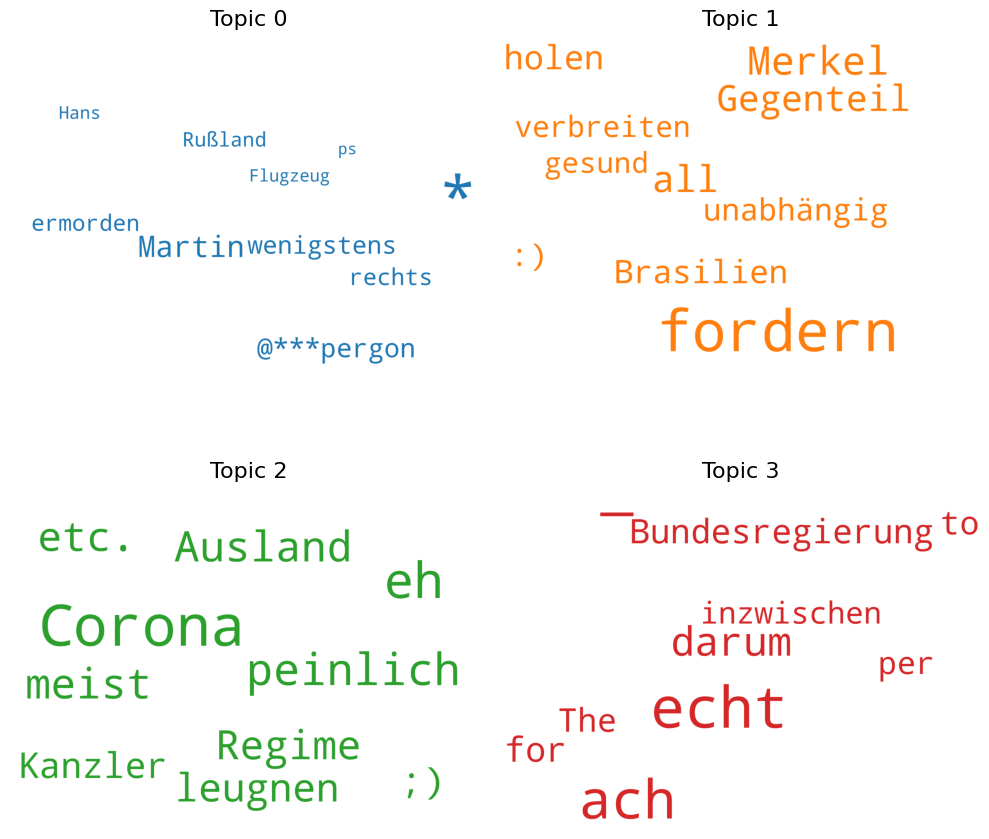

In [60]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white', width=2500, height=1800, max_words=10, colormap='tab10', color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_10.gensim")
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)